# EDA
Relatively quick check to see which features to drop/preprocess to get things going.

I. Inspect raw featurs and preprocess them to numeric format.  
II. Analyse processed features + additional feature engineering.

In [47]:
import sklearn
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer

% matplotlib inline
sns.set_style("darkgrid")
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (10, 5)

In [48]:
raw = pd.read_csv("../data/train.csv")
raw.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [49]:
# missing values
raw.isnull().sum()

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

## I. Raw Feature Inspection/Processing

Go through each feature and add/drop/process it accordingly

In [50]:
df = pd.DataFrame()

### 1. ticket 
Drop to save time

In [51]:
raw = raw.drop(["ticket"], axis=1)

### 2. cabin
Use Cabin first letter (floor?) as feature

In [52]:
raw["cabin"].isnull().sum()

687

In [53]:
# survival rate per cabin floor
raw.groupby(raw["cabin"].str[0])["survived"].mean()

cabin
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
Name: survived, dtype: float64

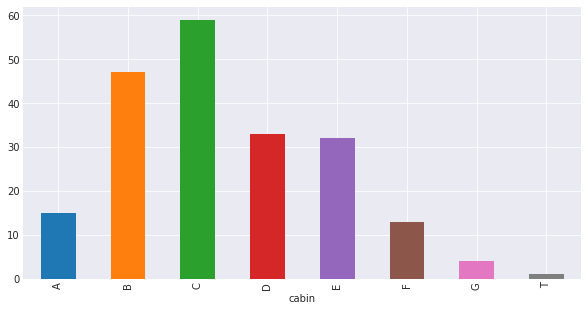

In [54]:
# distribution of cabins
raw.groupby(raw["cabin"].str[0])["survived"].count().plot(kind="bar")
plt.show()

In [55]:
# add feature
df["cabin_floor"] = LabelEncoder().fit_transform(raw["cabin"].str[0].fillna(""))

### 3. pclass
Keep pclass as is

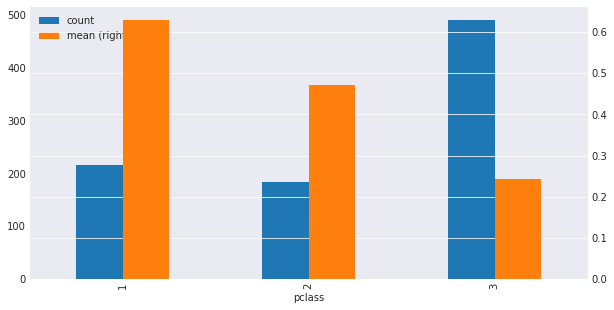

In [56]:
# distribution and survial rate based on pclass
raw.groupby("pclass")["survived"].describe()[["count", "mean"]].plot(kind="bar", secondary_y="mean")

In [57]:
# add to features
df["pclass"] = raw["pclass"]

### 4. sex
Use binary encoding

In [58]:
# conditionals
raw.groupby("sex")["survived"].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
female,314.0,0.742038,0.438211,0.0,0.0,1.0,1.0,1.0
male,577.0,0.188908,0.391775,0.0,0.0,0.0,0.0,1.0


In [59]:
# add to features
df["sex"] = LabelEncoder().fit_transform(raw["sex"])

### 5. Age
Keep as is, attention not to impute with 0

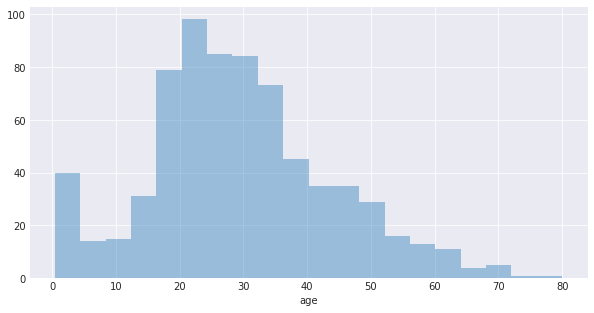

In [60]:
# Age distribution
sns.distplot(raw["age"].dropna(), kde=False)
plt.show()

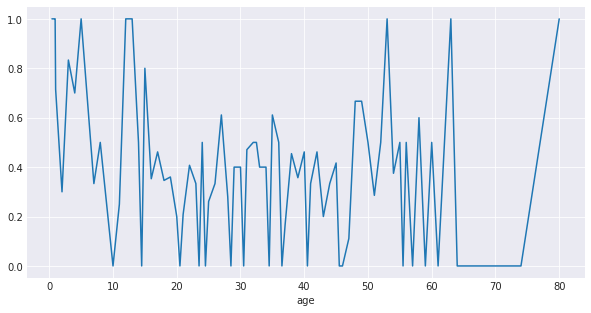

In [61]:
# conditional
raw.groupby("age")["survived"].mean().plot()
plt.show()

Extremes have a better survival rate - Expect to see a low linear correlation, parabolic corr would be a better indicator.  
Dropping the feature based on pearson corr would be a mistake.

In [62]:
# pearson corr
raw["age"].corr(raw["survived"])

-0.077221094572177643

In [63]:
# add feature
df["age"] = raw["age"]

### 6. fare
Keep as is

In [64]:
# expecting linear correlation
raw["fare"].corr(raw["survived"])

0.25730652238496232

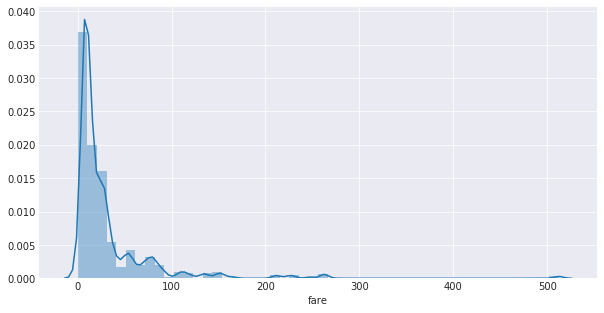

In [65]:
sns.distplot(raw["fare"])
plt.show()

In [66]:
df["fare"] = raw["fare"]

### 7. name
Create features based on last name.  
name_mean_survived, name_mean_fare, name_count  
!!! Attention to train test split to avoid data leak!!!  

In [67]:
names = raw["name"].str.split(",").apply(lambda x: x[0])
names.value_counts().describe()

count    667.000000
mean       1.335832
std        0.854922
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        9.000000
Name: name, dtype: float64

In [68]:
names.value_counts().head()

Andersson    9
Sage         7
Skoog        6
Goodwin      6
Panula       6
Name: name, dtype: int64

In [69]:
name_feats = raw.groupby(names)[["survived", "fare"]].mean()
name_feats["count"] = raw.groupby(names)["survived"].count()
name_feats = name_feats.reset_index()
#name_feats = name_feats.rename(columns={"survived": "name_mean_survived", "fare": "name_mean_fare"})
name_feats.head()

,name,survived,fare,count
0,Abbing,0.0,7.55,1
1,Abbott,0.5,20.25,2
2,Abelson,0.5,24.00,2
3,Adahl,0.0,7.25,1
4,Adams,0.0,8.05,1


In [70]:
name_feats = pd.merge(names.to_frame(), name_feats, left_on="name", right_on="name")
df["name_mean_survived"] = name_feats["survived"]
df["name_mean_fare"] = name_feats["fare"]
df["name_count"] = name_feats["count"]

### 8 - 9. sibsp and parch
Keep as they are

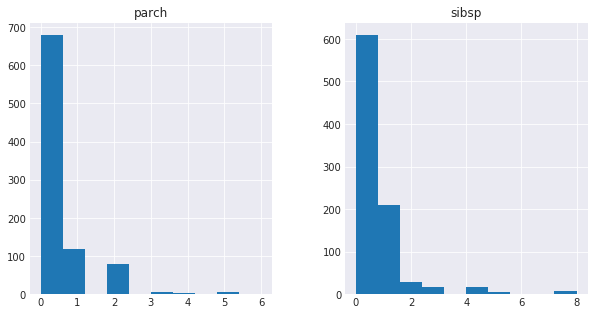

In [71]:
raw[["sibsp", "parch"]].hist()
plt.show()

In [72]:
# conditionals
raw.groupby("sibsp")["survived"].describe()

,count,mean,std,min,25%,50%,75%,max
sibsp,,,,,,,,
0,608.0,0.345395,0.475888,0.0,0.0,0.0,1.00,1.0
1,209.0,0.535885,0.499908,0.0,0.0,1.0,1.00,1.0
2,28.0,0.464286,0.507875,0.0,0.0,0.0,1.00,1.0
3,16.0,0.250000,0.447214,0.0,0.0,0.0,0.25,1.0
4,18.0,0.166667,0.383482,0.0,0.0,0.0,0.00,1.0
5,5.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0
8,7.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.0


In [73]:
raw.groupby("parch")["survived"].describe()

,count,mean,std,min,25%,50%,75%,max
parch,,,,,,,,
0,678.0,0.343658,0.475279,0.0,0.0,0.0,1.0,1.0
1,118.0,0.550847,0.499529,0.0,0.0,1.0,1.0,1.0
2,80.0,0.500000,0.503155,0.0,0.0,0.5,1.0,1.0
3,5.0,0.600000,0.547723,0.0,0.0,1.0,1.0,1.0
4,4.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
5,5.0,0.200000,0.447214,0.0,0.0,0.0,0.0,1.0
6,1.0,0.000000,NaN,0.0,0.0,0.0,0.0,0.0


In [74]:
df[["sibsp", "parch"]] = raw[["sibsp", "parch"]]

### 10. Embarked
One hot encoding

In [75]:
# conditionals 
raw.groupby("embarked")["survived"].describe()

,count,mean,std,min,25%,50%,75%,max
embarked,,,,,,,,
C,168.0,0.553571,0.498608,0.0,0.0,1.0,1.0,1.0
Q,77.0,0.389610,0.490860,0.0,0.0,0.0,1.0,1.0
S,644.0,0.336957,0.473037,0.0,0.0,0.0,1.0,1.0


In [76]:
cols = ["embarked_" + str(i) for i in range(4)]
df = pd.concat([df, pd.DataFrame(LabelBinarizer().fit_transform(raw["embarked"].fillna("X")), columns=cols)], axis=1)

### 11. Survived
The endogenous variable, not much to do here

In [77]:
# class imabalance
raw["survived"].mean()

0.3838383838383838

In [78]:
df["survived"] = raw["survived"]

## II. Feature Analysis
Analysing the features produces in step I.  
Feature selection, decorrelation, outlier detection etc comes here  

In [79]:
df.describe()

,cabin_floor,pclass,sex,age,fare,name_mean_survived,name_mean_fare,name_count,sibsp,parch,embarked_0,embarked_1,embarked_2,embarked_3,survived
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.776655,2.308642,0.647587,29.699118,32.204208,0.383838,32.204208,1.882155,0.523008,0.381594,0.188552,0.086420,0.722783,0.002245,0.383838
std,1.590899,0.836071,0.477990,14.526497,49.693429,0.442167,48.951667,1.488014,1.102743,0.806057,0.391372,0.281141,0.447876,0.047351,0.486592
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,20.125000,7.910400,0.000000,8.050000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,3.000000,1.000000,28.000000,14.454200,0.000000,14.500000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,3.000000,1.000000,38.000000,31.000000,1.000000,31.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,8.000000,3.000000,1.000000,80.000000,512.329200,1.000000,512.329200,9.000000,8.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 1. Missing Values
Only age has to be imputed, creating separate feature with missing_age

In [80]:
df["missing_age"] = df["age"].isnull().astype(int)
df["age"] = df["age"].fillna(0)

### 2. Correlation
Some high correlations, but nothing being extreme

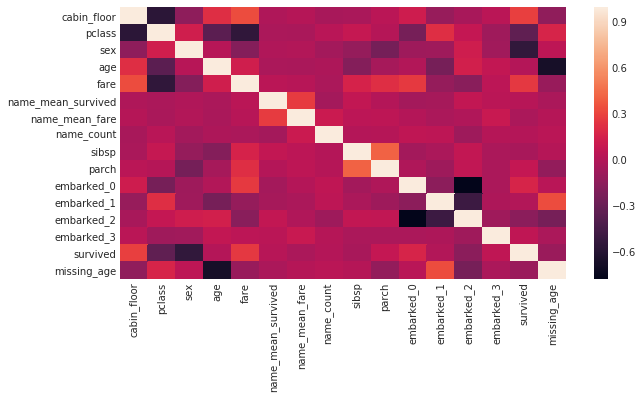

In [81]:
sns.heatmap(df.corr())
plt.show()

In [82]:
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

pca = PCA().fit(RobustScaler().fit_transform(df))
pca.explained_variance_ratio_

array([  3.08842717e-01,   2.54023655e-01,   1.22670316e-01,
         1.17387453e-01,   7.21765164e-02,   2.80076831e-02,
         2.59234140e-02,   1.96484127e-02,   1.42554181e-02,
         1.34288087e-02,   9.59888814e-03,   5.93890102e-03,
         4.99812974e-03,   2.93924954e-03,   1.60438213e-04,
         8.12919348e-34])

### 3. Distributions/Outliers
"fare" seems to be the only one with outliers, not that extreme so ill just ignore it

cabin_floor


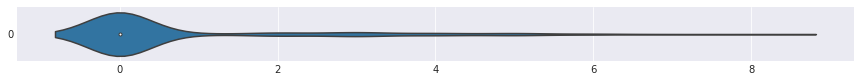

pclass


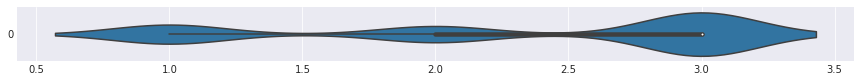

sex


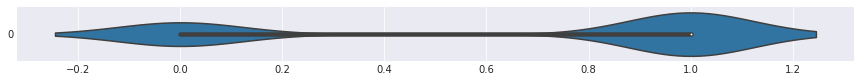

age


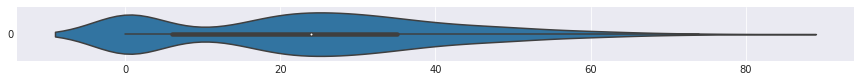

fare


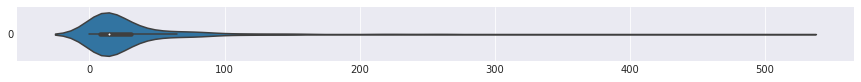

name_mean_survived


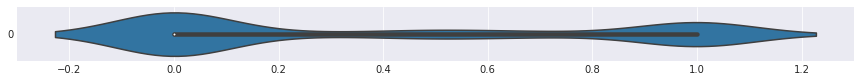

name_mean_fare


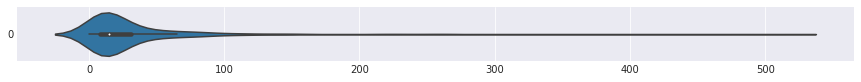

name_count


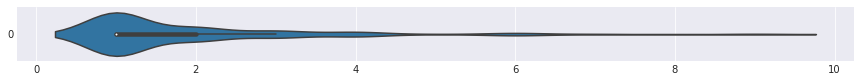

sibsp


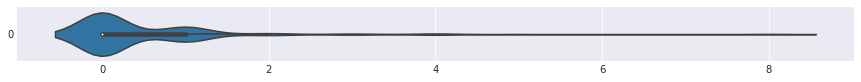

parch


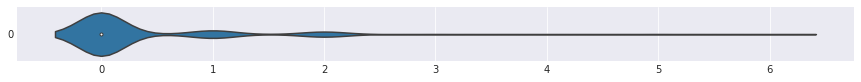

embarked_0


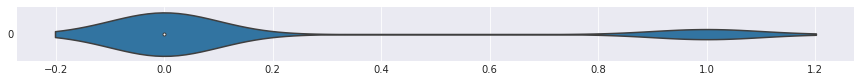

embarked_1


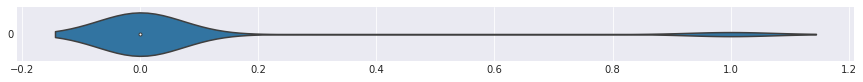

embarked_2


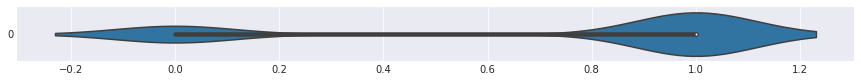

embarked_3


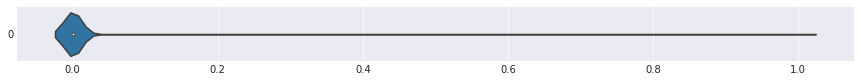

survived


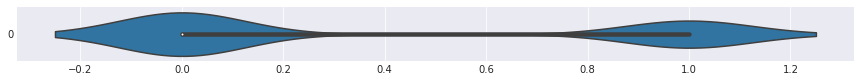

missing_age


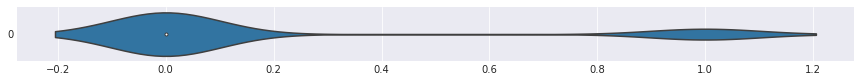

In [83]:
for col in df.columns:
    print(col)
    plt.figure(figsize=(15,1))
    sns.violinplot(data=df[col], orient="h")
    plt.show()

### 4. Final DF
Df will have to recomputed before modelling, just on the train split

In [84]:
df = pd.DataFrame(RobustScaler().fit_transform(df), columns=df.columns)
df.describe()

,cabin_floor,pclass,sex,age,fare,name_mean_survived,name_mean_fare,name_count,sibsp,parch,embarked_0,embarked_1,embarked_2,embarked_3,survived,missing_age
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.776655,-0.691358,-0.352413,-0.006921,0.768745,0.383838,0.771425,0.882155,0.523008,0.381594,0.188552,0.086420,-0.277217,0.002245,0.383838,0.198653
std,1.590899,0.836071,0.477990,0.606761,2.152200,0.442167,2.132970,1.488014,1.102743,0.806057,0.391372,0.281141,0.447876,0.047351,0.486592,0.399210
min,0.000000,-2.000000,-1.000000,-0.827586,-0.626005,0.000000,-0.631808,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,0.000000,-1.000000,-1.000000,-0.620690,-0.283409,0.000000,-0.281046,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.379310,0.716591,1.000000,0.718954,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,8.000000,0.000000,0.000000,1.931034,21.562738,1.000000,21.691904,8.000000,8.000000,6.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000


### 5. Embedded vis
Getting some nice separation already

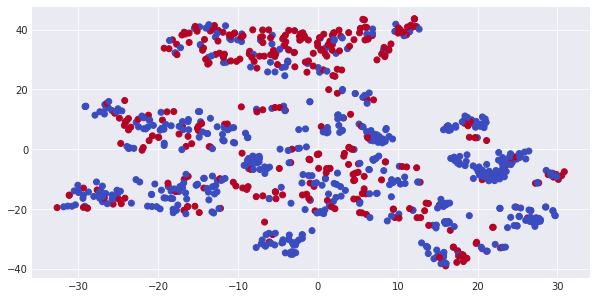

In [85]:
from sklearn.manifold import TSNE

embd = TSNE().fit_transform(df.drop("survived", axis=1))
plt.scatter(embd[:, 0], embd[:, 1], cmap="coolwarm", c=df["survived"])